# Определение стоимости автомобилей

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [2]:
data = pd.read_csv("autos.csv", index_col=[0])
display(data.head())
print(data.shape)
print()
print(data.info())
print()
print('Количество дубликатов', data.duplicated().sum())
print()
print('Количество пропусков')
print(100*data.isna().sum()/len(data))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


(354369, 16)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int

Внушительный датасет из > 350к записей. Отмечаем следующие проблемы с данными:
- Пропуски в данных, столбцы: Тип кузова, коробка передач, модель авто, тип топлива для двигателя, чинилась ли?
- Лишние строки для обучения: поскольку нет цели определить сколько стоил авто в какой-то момент, столбцы DateCrawled и LastSeen, DateCreated бесполезны для обучения.
- Выделили следующие категориальные признаки, которые обработаем техникой OHE: VehicleType, Gearbox, Model, FuelType, Brand, NotRepaired.
- Проблемы с типами данных только в категориальных столбцах

Начнем с признаков с пропущенными значениями

In [3]:
cars = data.copy()
cars = cars.drop(columns = ['DateCrawled', 'LastSeen', 'DateCreated'])
display(cars.head())
print(cars['VehicleType'].unique())

#Заменим на новое значение все пропуски в столбце VehicleType
cars['VehicleType'] = cars['VehicleType'].fillna('other')
#print(cars['VehicleType'].unique())

#Заменим на новое значение все пропуски в столбце Gearbox
print(cars['Gearbox'].unique())
cars['Gearbox'] = cars['Gearbox'].fillna('unknown')
print(cars['Gearbox'].unique())

# Авто без указания модели явно удаляем, слишком важный параметр, да и данных не так много - около 5%.
cars = cars.dropna(subset = ['Model'])
#print(cars.info())
print()

#Заменим на новое значение все пропуски в столбце FuelType
print(cars['FuelType'].unique())
cars['FuelType'] = cars['FuelType'].fillna('other')
#print(cars['FuelType'].unique())
print()

#Заменим на новое значение все пропуски в столбце NotRepaired
cars['NotRepaired'] = cars['NotRepaired'].fillna('unknown')
print(cars['NotRepaired'].unique())
cars.info()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures,PostalCode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,0,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0,60437


[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
['manual' 'auto' nan]
['manual' 'auto' 'unknown']

['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']

['unknown' 'no' 'yes']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 334664 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              334664 non-null  int64 
 1   VehicleType        334664 non-null  object
 2   RegistrationYear   334664 non-null  int64 
 3   Gearbox            334664 non-null  object
 4   Power              334664 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          334664 non-null  int64 
 7   RegistrationMonth  334664 non-null  int64 
 8   FuelType           334664 non-null  object
 9   Brand              334664 non-null  object
 10  NotRepaired        334664 non-null  object
 11  NumberOfPictures   334664 non-null  int64 
 12 

Посмотрим на выбросы:

In [4]:
print(cars['RegistrationYear'].describe())
print()
print('Сколько авто с регистрацией до 1950 года:', cars[cars['RegistrationYear'] < 1950]['Price'].count())
print('Сколько авто с регистрацией после 2021 года:', cars[cars['RegistrationYear'] > 2021]['Price'].count())
#явно стоит удалить эти значения
cars = cars[(cars['RegistrationYear'] > 1950) & (cars['RegistrationYear'] < 2022)]
print(cars['RegistrationYear'].unique())
print(len(cars))
#С этими выбросами закончили, перейдем к мощности авто:


count    334664.000000
mean       2003.923992
std          69.377219
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Сколько авто с регистрацией до 1950 года: 121
Сколько авто с регистрацией после 2021 года: 63
[1993 2004 2001 2008 1995 1980 2014 1998 2005 2011 2016 2007 2009 2002
 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010 2000
 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1969 1971 1987 1986
 1988 1965 1970 1974 1955 1978 1979 1972 1968 1977 1961 1960 1966 1975
 1963 1954 1967 1964 1962 2019 1951 1959 1953 1958 1956 1952 1957]
334466



Сколько авто с мощностью до 3 л.с.: 33832
Сколько авто с мощностью более 1000 л.с.: 260
[  0 163  75  69 102 109  50 125 101 105 140 115 131 190  60 136 160 231
  90 118 193  99 113 218 122 129  70 306  95  61 177  80 170  55 143  64
 232 150 156  82 155 185  87 180  86  84 224 235 200 178 265  77 110 144
 120  54 286 116 184 126 204  88 194 305 197 179 250 313  41  45 165  98
 130 114 211  56 201 213  58 107  83 174 100 220  85  73 192  66 299  74
  52 147  65 310  71  97 239  68 203 300 103 258 320  63  81 148  44 145
 280 260 104 188 333 117 141  59 132 234 158  39  92  51 135 230  53 209
  43 146  67 106 166 276 344  72 237 245 111 326 279  23 138 175  96 226
 301 334 128 133 124  33 219 241 167 182 196 238 228  48 272 139 240 186
  79 256 243 375 252 396 340 108 121 187 289 222 198 284  37 450 233 112
 387 152 347 172  57 137  94 212 476 314  30   7  47  26 173 290 207 205
 171  78  91  89 349  40 325  76 151 953  93 142 500 343 199 164  16 367
 208 210  46 435 225 127 176 161 60

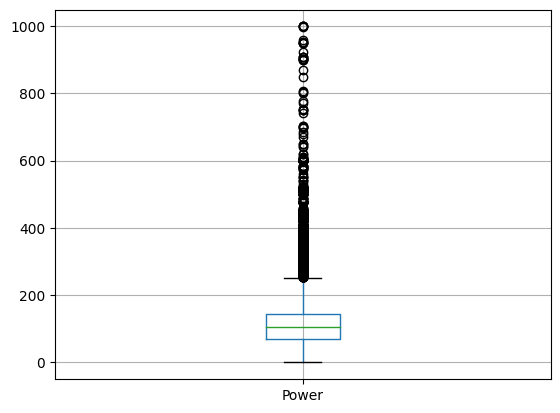

In [5]:
#cars.boxplot(column = 'Power')
print()
print('Сколько авто с мощностью до 3 л.с.:', cars[cars['Power'] < 3]['Price'].count())
print('Сколько авто с мощностью более 1000 л.с.:', cars[cars['Power'] > 1000]['Price'].count())
#более 1000 лс удаляем
cars = cars[(cars['Power'] < 1000)]
print(cars['Power'].unique())
print(len(cars))
cars.boxplot(column = 'Power')
#Изучим строки с мощностью менее 3 л.с.:
#print(cars[cars['Power'] <3].tail(15))
#Явно это просто не внесенная в анкету информация, авто марок opel и bmw с 0 л.с. не бывает..
print(cars[cars['Power'] < 40].head(10))
print(cars[cars['Power'] < 40]['Price'].count())
#Просмотрев информацию по строкам с 1, 2 л.с. также не назодим ни мопедов, ни велосипедов, поэтому принимаем решение удалить 
#значения Мощности менее 40 л.с. 35 тыс строк конечно жалко, но точности модели они не добавят..
cars = cars[(cars['Power'] > 40)]
print(len(cars))

count    299024.000000
mean       4768.895490
std        4602.614697
min           0.000000
25%        1299.000000
50%        3000.000000
75%        6900.000000
max       20000.000000
Name: Price, dtype: float64
6994
291491


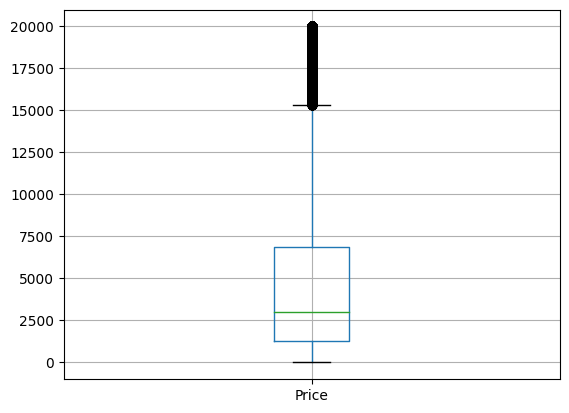

In [6]:
#перейдем наконец к Стоимости авто
print(cars['Price'].describe())
cars.boxplot(column = 'Price')
#бросаются в глаза нулевые значения
print(cars[cars['Price'] < 100]['Price'].count())
#7 тыс строк придется также удалить
cars = cars[cars['Price'] > 100]
print(len(cars))

Выбросов действительно много, и теперь появляется надежда на существенное улучшение прогнозов моделей. Теперь обработаем категориальные признаки техникой OHE

In [7]:
cars_ohe = pd.get_dummies(cars, drop_first = True)
display(cars_ohe.head())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_other,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
2,9800,2004,163,125000,8,0,90480,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,6,0,91074,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,7,0,60437,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,10,0,33775,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,2200,2004,109,150000,8,0,67112,1,0,0,...,0,0,0,0,0,0,0,0,0,0


OHE проверили, пора подготовить наборы для обучения, проведем масштабирование признаков:

In [8]:
target = cars_ohe['Price']
features = cars_ohe.drop(['Price'], axis = 1)

#Подготовка обучающей, валидационной и тестовой выборок:
features_train, features_second, target_train, target_second = train_test_split(features, target, test_size = 0.4, random_state = 12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_second, target_second, test_size = 0.5, random_state = 12345)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

#Масшиабирование признаков:
scaler = StandardScaler()
scaler.fit(features[features.columns])

features_train[features.columns] = scaler.transform(features_train[features.columns])
features_valid[features.columns] = scaler.transform(features_valid[features.columns])
features_test[features.columns] = scaler.transform(features_test[features.columns])

(174894, 309)
(58298, 309)
(58299, 309)


## Обучение моделей

Начнем с линейной регрессии:

In [9]:
%%time
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

#Для сравнения посмотрим, а какова средняя цена авто
print('Средняя цена авто:', cars_ohe['Price'].mean())

Средняя цена авто: 4891.85320987612
CPU times: user 17.1 s, sys: 13.5 s, total: 30.6 s
Wall time: 7.92 s


In [10]:
%%time

lr_predictions = model_lr.predict(features_test)

CPU times: user 175 ms, sys: 250 ms, total: 424 ms
Wall time: 103 ms


In [11]:
print('RMSE составляет:', mean_squared_error(target_test, lr_predictions) ** 0.5)

RMSE составляет: 2542.659775212655


Линейная регрессия показала весьма слабенькие результаты, но быстро обучилась, всего 17,7 сек. Перейдем теперь к случайному лесу, проверим сначала метрику на параметрах по умолчанию, потом подберем параметры:

In [12]:
%%time
model_rf = RandomForestRegressor(random_state = 12345)
model_rf.fit(features_train, target_train)

CPU times: user 3min 6s, sys: 1.57 s, total: 3min 7s
Wall time: 3min 7s


RandomForestRegressor(random_state=12345)

In [13]:
%%time
rf_predictions = model_rf.predict(features_test)

CPU times: user 1.89 s, sys: 325 ms, total: 2.22 s
Wall time: 2.26 s


In [14]:
print('RMSE составляет:', mean_squared_error(target_test, rf_predictions) ** 0.5)

RMSE составляет: 1553.6135286854517


In [15]:
best_model_rf = None
best_result = 10000
best_depth = 0
best_estim = 0

for depth in range(5, 40, 3):
    model_rf = RandomForestRegressor(random_state = 12345, max_depth = depth)
    model_rf.fit(features_train, target_train)
    predictions = model_rf.predict(features_valid)
    result = mean_squared_error(target_valid, predictions) ** 0.5
    print('При max_depth =', depth, 'RMSE составляет', result)
    if result < best_result:
        best_model_rf = model_rf
        best_result = result
        best_depth = depth

print("RMSE наилучшей модели на валидационной выборке:", best_result, "при глубине дерева ", best_depth)

При max_depth = 5 RMSE составляет 2422.480133138719
При max_depth = 8 RMSE составляет 2024.6150391203964
При max_depth = 11 RMSE составляет 1814.2071151013554
При max_depth = 14 RMSE составляет 1693.0037909382813
При max_depth = 17 RMSE составляет 1622.9256829768367
При max_depth = 20 RMSE составляет 1585.5860201847909
При max_depth = 23 RMSE составляет 1566.4516036883556
При max_depth = 26 RMSE составляет 1557.0923821018596
При max_depth = 29 RMSE составляет 1552.784626965654
При max_depth = 32 RMSE составляет 1550.0336615575463
При max_depth = 35 RMSE составляет 1549.5040366866192
При max_depth = 38 RMSE составляет 1549.3449171343825
RMSE наилучшей модели на валидационной выборке: 1549.3449171343825 при глубине дерева  38


In [16]:
#повторно не прогоняем
best_result = 10000
for estim in range(50, 310, 50):
    model_rf = RandomForestRegressor(random_state = 12345, max_depth = 4, n_estimators = estim)
    model_rf.fit(features_train, target_train)
    predictions = model_rf.predict(features_valid)
    result = mean_squared_error(target_valid, predictions) ** 0.5
    print('При n_estimators =', estim, 'RMSE составляет', result)
    if result < best_result:
        best_result = result
        best_estim = estim

print("RMSE наилучшей модели на валидационной выборке:", best_result, "при глубине дерева ", best_depth, 'и количестве деревьев', best_estim)

При n_estimators = 50 RMSE составляет 2640.823985671797
При n_estimators = 100 RMSE составляет 2639.7976631527645
При n_estimators = 150 RMSE составляет 2639.747973850506
При n_estimators = 200 RMSE составляет 2639.439093548804
При n_estimators = 250 RMSE составляет 2639.5090059893937
При n_estimators = 300 RMSE составляет 2639.500839182065
RMSE наилучшей модели на валидационной выборке: 2639.439093548804 при глубине дерева  38 и количестве деревьев 200


In [17]:
%%time
best_model_rf = RandomForestRegressor(random_state = 12345, max_depth = 35, n_estimators = 200)
best_model_rf.fit(features_train, target_train)

CPU times: user 6min 1s, sys: 2.57 s, total: 6min 3s
Wall time: 6min 3s


RandomForestRegressor(max_depth=35, n_estimators=200, random_state=12345)

In [18]:
%%time
best_rf_predictions = best_model_rf.predict(features_test)

CPU times: user 3.4 s, sys: 795 ms, total: 4.2 s
Wall time: 4.39 s


In [19]:
print('RMSE лучшей модели Случайного леса на тестовой выборке составляет:', mean_squared_error(target_test, best_rf_predictions) ** 0.5)

RMSE лучшей модели Случайного леса на тестовой выборке составляет: 1550.3519047166324


Значение метрики RMSE на параметрах по умолчанию на 35% меньше чем у линейной регрессии (1641), время обучения 67 сек, т.е. в 3.5 раза дольше. Результаты подбора параметров сформулируем так:

- Наилучшие параметры модели: max_depth = 35, n_estimators = 200.
- Суммарное время подбора параметров: около 1 часа
- RMSE на валидационной выборке при этом снизилась до 1641

Проверим теперь качество работы модели на тестовой выборке и зафиксируем время обучения. Итого - RMSE составила 1550, а обучилась модель за 17.5 мин.

Перейдем к CatBoost. Поскольку он умеет работать с категориальными признаками, подготовим признаки из датафрейма, не обработанного техникой OHE. Прогоним для начала со значениями по умолчанию:

In [20]:
target = cars['Price']
features = cars.drop(['Price'], axis = 1)

#Подготовка обучающей, валидационной и тестовой выборок:
features_train, features_second, target_train, target_second = train_test_split(features, target, test_size = 0.4, random_state = 12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_second, target_second, test_size = 0.5, random_state = 12345)

print(features.head(1))

#Масшиабирование признаков:
list_for_scaler = ['Power', 'Kilometer']
scaler = StandardScaler()
scaler.fit(features[list_for_scaler])

features_train[list_for_scaler] = scaler.transform(features_train[list_for_scaler])
features_valid[list_for_scaler] = scaler.transform(features_valid[list_for_scaler])
features_test[list_for_scaler] = scaler.transform(features_test[list_for_scaler])

from catboost import CatBoostRegressor

cat_features = ['VehicleType', 'Gearbox', 'Model',
                'FuelType', 'Brand', 'NotRepaired', 'RegistrationYear', 'RegistrationMonth', 'PostalCode']
print(features_train.head(1))

  VehicleType  RegistrationYear Gearbox  Power  Model  Kilometer  \
2         suv              2004    auto    163  grand     125000   

   RegistrationMonth  FuelType Brand NotRepaired  NumberOfPictures  PostalCode  
2                  8  gasoline  jeep     unknown                 0       90480  
      VehicleType  RegistrationYear Gearbox     Power  Model  Kilometer  \
79758       small              2000  manual -1.131658  punto    0.58911   

       RegistrationMonth FuelType Brand NotRepaired  NumberOfPictures  \
79758                  8   petrol  fiat          no                 0   

       PostalCode  
79758       28219  


In [21]:
%%time
model_cb = CatBoostRegressor(loss_function='RMSE', random_seed = 12345)

model_cb.fit(features_train, target_train, cat_features=cat_features, verbose=50) 


Learning rate set to 0.092584
0:	learn: 4292.0706553	total: 126ms	remaining: 2m 6s
50:	learn: 1819.9813561	total: 2.43s	remaining: 45.2s
100:	learn: 1719.0614001	total: 4.57s	remaining: 40.6s
150:	learn: 1673.0813144	total: 6.83s	remaining: 38.4s
200:	learn: 1642.1855149	total: 8.98s	remaining: 35.7s
250:	learn: 1619.0502415	total: 11.2s	remaining: 33.5s
300:	learn: 1605.5011505	total: 13.3s	remaining: 31s
350:	learn: 1590.8205356	total: 15.5s	remaining: 28.7s
400:	learn: 1579.4128473	total: 17.9s	remaining: 26.7s
450:	learn: 1569.6082328	total: 20.1s	remaining: 24.5s
500:	learn: 1560.5071570	total: 22.3s	remaining: 22.2s
550:	learn: 1552.6300636	total: 24.6s	remaining: 20s
600:	learn: 1544.2912212	total: 26.8s	remaining: 17.8s
650:	learn: 1537.6633862	total: 29.1s	remaining: 15.6s
700:	learn: 1531.0930832	total: 31.5s	remaining: 13.4s
750:	learn: 1524.6997639	total: 33.9s	remaining: 11.2s
800:	learn: 1518.6550309	total: 36.2s	remaining: 8.99s
850:	learn: 1513.2790018	total: 38.6s	rema

In [22]:
%%time
cb_predictions = model_cb.predict(features_test)
result = mean_squared_error(target_test, cb_predictions) ** 0.5


CPU times: user 791 ms, sys: 18.1 ms, total: 809 ms
Wall time: 190 ms


In [23]:
print('RMSE обученной модели на тестовой выборке составила', result)


RMSE обученной модели на тестовой выборке составила 1557.052811803514


In [24]:
best_model_cb = None
best_result = 10000
best_depth = 0
best_learning_rate = 0

for depth in range(13,17,1):
    print(depth)
    model_cb = CatBoostRegressor(loss_function="RMSE", depth = depth, iterations=100)
    model_cb.fit(features_train, target_train, cat_features=cat_features, verbose=20)
    cb_predictions = model_cb.predict(features_valid)
    result = mean_squared_error(target_valid, cb_predictions) ** 0.5
    print('RMSE обученной модели на валидационной выборке составил', result)
    if result < best_result:
        best_result = result
        best_depth = depth
       
        
print('Оптимальное значение параметра depth', best_depth)

13
Learning rate set to 0.5
0:	learn: 2968.2443914	total: 74.3ms	remaining: 7.36s
20:	learn: 1445.3857409	total: 1.27s	remaining: 4.79s
40:	learn: 1303.2655959	total: 2.38s	remaining: 3.42s
60:	learn: 1217.8820242	total: 3.54s	remaining: 2.26s
80:	learn: 1143.0632127	total: 4.67s	remaining: 1.09s
99:	learn: 1095.6932581	total: 5.74s	remaining: 0us
RMSE обученной модели на валидационной выборке составил 1614.5516748229375
14
Learning rate set to 0.5
0:	learn: 2955.0504091	total: 138ms	remaining: 13.7s
20:	learn: 1395.7886772	total: 2.34s	remaining: 8.79s
40:	learn: 1227.7642029	total: 4.54s	remaining: 6.54s
60:	learn: 1116.3950071	total: 6.7s	remaining: 4.28s
80:	learn: 1022.7290794	total: 8.83s	remaining: 2.07s
99:	learn: 944.9652789	total: 10.9s	remaining: 0us
RMSE обученной модели на валидационной выборке составил 1624.48755227454
15
Learning rate set to 0.5
0:	learn: 2942.1609265	total: 255ms	remaining: 25.3s
20:	learn: 1337.3215622	total: 4.7s	remaining: 17.7s
40:	learn: 1124.69213

Наилучшие результаты при глубине 13

In [25]:
best_result = 10000


for lrate in np.arange(0.01,0.20,0.03):
    print(lrate)
    model_cb = CatBoostRegressor(loss_function="RMSE", iterations=100, learning_rate = lrate)
    model_cb.fit(features_train, target_train, cat_features=cat_features, verbose=20)
    cb_predictions = model_cb.predict(features_valid)
    result = mean_squared_error(target_valid, cb_predictions) ** 0.5
    print('RMSE обученной модели на валидационной выборке составил', result)
    print()
    if result < best_result:
        best_result = result
        best_learning_rate = lrate
        
        
print('Оптимальное значение параметра learning_rate', best_learning_rate)

0.01
0:	learn: 4554.6743419	total: 19ms	remaining: 1.88s
20:	learn: 3992.2077202	total: 345ms	remaining: 1.3s
40:	learn: 3550.1637370	total: 663ms	remaining: 955ms
60:	learn: 3197.1063356	total: 993ms	remaining: 635ms
80:	learn: 2919.4241031	total: 1.32s	remaining: 309ms
99:	learn: 2710.8590994	total: 1.62s	remaining: 0us
RMSE обученной модели на валидационной выборке составил 2728.809693875727

0.04
0:	learn: 4460.8057106	total: 20.9ms	remaining: 2.07s
20:	learn: 2870.4413086	total: 348ms	remaining: 1.31s
40:	learn: 2266.3985358	total: 659ms	remaining: 949ms
60:	learn: 2034.5059257	total: 984ms	remaining: 629ms
80:	learn: 1931.7531553	total: 1.33s	remaining: 311ms
99:	learn: 1878.1667181	total: 1.66s	remaining: 0us
RMSE обученной модели на валидационной выборке составил 1891.5678798665688

0.06999999999999999
0:	learn: 4367.8983419	total: 19.8ms	remaining: 1.96s
20:	learn: 2339.6861351	total: 344ms	remaining: 1.29s
40:	learn: 1969.7459074	total: 668ms	remaining: 961ms
60:	learn: 1865.

Пробежав параметры от 0.01 до 0,2 выбираем оптимальную скорость обучения - 0.19.

In [26]:
%%time
model_cb = CatBoostRegressor(loss_function="RMSE", depth = 13, learning_rate=0.19, iterations = 180)
model_cb.fit(features_train, target_train, cat_features=cat_features, verbose=10)


0:	learn: 3922.1838183	total: 241ms	remaining: 43.1s
10:	learn: 1736.4769997	total: 2.37s	remaining: 36.4s
20:	learn: 1519.4948421	total: 4.49s	remaining: 34s
30:	learn: 1442.5100035	total: 6.69s	remaining: 32.2s
40:	learn: 1380.3086198	total: 8.94s	remaining: 30.3s
50:	learn: 1326.6605264	total: 11.1s	remaining: 28.2s
60:	learn: 1285.8982548	total: 13.3s	remaining: 26s
70:	learn: 1241.8078929	total: 15.6s	remaining: 24s
80:	learn: 1205.1588824	total: 17.8s	remaining: 21.8s
90:	learn: 1170.8134061	total: 20s	remaining: 19.5s
100:	learn: 1132.7206100	total: 22.2s	remaining: 17.3s
110:	learn: 1098.3972574	total: 24.5s	remaining: 15.2s
120:	learn: 1068.9854300	total: 26.7s	remaining: 13s
130:	learn: 1046.7696428	total: 28.9s	remaining: 10.8s
140:	learn: 1021.3964348	total: 31s	remaining: 8.58s
150:	learn: 998.8909040	total: 33.2s	remaining: 6.38s
160:	learn: 975.9492369	total: 35.4s	remaining: 4.17s
170:	learn: 953.5718025	total: 37.5s	remaining: 1.98s
179:	learn: 934.7984628	total: 39.6s

In [27]:
%%time
cb_predictions = model_cb.predict(features_test)
result = mean_squared_error(target_test, cb_predictions) ** 0.5


CPU times: user 170 ms, sys: 6.58 ms, total: 176 ms
Wall time: 84.7 ms


In [28]:
print('RMSE обученной модели на тестовой выборке составил', result)

RMSE обученной модели на тестовой выборке составил 1569.8043546084414


Подведем итоги по CatBoost:
- Наилучшие параметры модели: depth = 13, learning_rate = 0.19
- Суммарное время подбора параметров: около 1 часа
- Обучение модели с приведенным выше параметрами составило 5 минут
- RMSE на тестовой выборке выборке при этом снизилась до 1564
При том какие результаты можно было бы получить при увеличении количества итераций - впечатляет..


Объединим результаты исследования в наглядную таблицу и перейдем к выводам

In [29]:
columns = ['Значение RMSE', 'Время обучения модели, мин', 'Время предсказания, сек']
resdata = [
    [2542, 0.27, 0.21],
    [1641, 1.1, 0.43],
    [1550, 17.5, 10],
    [1614, 16, 1.7],
    [1564, 5.3, 0.57]]

lists = ['Линейная регрессия', 'Случайный лес (умолч.)','Случайный лес (подгон)','CatBoost (умолч.)','CatBoost (подгон)']

resshow = pd.DataFrame(data = resdata, columns = columns, index = lists)


## Анализ моделей

In [30]:
display(resshow)

,Значение RMSE,"Время обучения модели, мин","Время предсказания, сек"
Линейная регрессия,2542,0.27,0.21
Случайный лес (умолч.),1641,1.10,0.43
Случайный лес (подгон),1550,17.50,10.00
CatBoost (умолч.),1614,16.00,1.70
CatBoost (подгон),1564,5.30,0.57


# Выводы

В данном проекте на примере построения модели оценки стоимости авто испробованы различные модели, линейная регрессия, случайный лес, модель градиентного бустинга CatBoost. 

1. Линейная регрессия, несмотря на быстрое время обучения, не впечатлила результатами.. Быстро и плохо. Связано это, как мне кажется, в первую очередь с большим количеством категориальных параметров.
2. Случайный лес. Неплохой результат на настройках по умолчанию, да и время обучения - чуть менее 1 минуты. Подбор параметров занимает долгое время, и не столь существенно увеличивает результаты (улучшение в 4% относительно исходных параметров). Отметим и существенное время обучения модели с подобранными параметрами - 18 минут.
3. CatBoost. Первое, что позволяет мождель - использовать набор признаков, не обработанный техникой OHE, очень удобно, но насколько я понимаю это и существенно тормозит обучение. Отметим, что очень долгое время обучения не позволило прогнать большое количество параметров и тщательно их подогнать, в связи с чем результаты подогнанной модели незначительно лучше чем по умолчанию, они получены всего при 180 итерациях, модель обучилась всего за 5 минут. Отлично отработала модель на базовых настройках, лучший результат из всех моделей, но обучалась заметно дольше. В целом, понимая каких результатов можно было бы достичь при 500-1000 итераций, качество работы модели впечатляет.
4. По скорости прогнозирования скажем, что линейная регрессия также быстра (но не точна), случайный лес существенно дольше работает чем модель CatBoost. CatBoost на данной задаче позволяет выиграть во времени прогнозирования, разницу оценить сложно, но это разы (по моим прикидкам, на моделях, выдающих схожие результаты - в разы).

